In [40]:
import pandas as pd
#File Path definieren und Daten einlesen
file_path1 = '/Users/alexandragort/Documents/Uni/BA&DSA/assignment.csv'
file_path2 = '/Users/alexandragort/Documents/Uni/BA&DSA/kaggle.csv'
train = pd.read_csv(file_path1)
comp_data = pd.read_csv(file_path2)

In [41]:
#droppen der Kategorischen Daten
train = train.select_dtypes(exclude=['object'])
comp_data = comp_data.select_dtypes(exclude=['object'])

# Model 1: XGBoost Regression

>Ich werde als erstes Modell die XGBoost Regression verwenden, weil dieses Modell für eine grosse Variation an tasks angwendet werden, seien dies Klassifikations-, Regressions-, Ranking- und viele weitere Probleme. Und man kann auch sehr viele Parameter bestimmen, weshalb ich hoffe das ich dadurch ein möglichst gutes Model basteln kann.
>Quelle: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

In [42]:
from sklearn.model_selection import train_test_split

X = train.drop('value_eur', axis=1)  # alle features ohne target
y = train['value_eur']  # Target variable

# Splitten des Datasets in trainings und test daten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, shuffle=True)

***XGBOOST mit GridsearchCV und CrossValidation:***
>Quelle für den Code: https://youtu.be/TvB_3jVIHhg?feature=shared, und ChatGPT für ErrorKorrektionen sowie hinzufügen der RMSE Score Metrik.

In [43]:
#grid search nur auf den trainingsdaten angewenden
#definieren des Base Models: XGB
!pip install xgboost
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state = 44)

In [44]:
#Implementieren der Gridsearch:
#Erstellen eines Dictionarys für die Hyperparameter Werte:
search_space = {
    "n_estimators" : [100, 200, 500],
    "max_depth" : [3, 6, 9],
    "gamma" : [0.01, 0.1],
    "learning_rate" : [0.01, 0.01, 0.1, 1],
}

In [45]:
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, mean_squared_error
#Hinzufügen der RMSE Score
scorers = {
    "RMSE": make_scorer(mean_squared_error, squared=False, greater_is_better=False)
}

In [46]:
#Erstellen eines gridsearch Objekts:
GS = GridSearchCV(
    estimator=xgb_model,
    param_grid=search_space,
    scoring=scorers,
    refit="RMSE",  # RMSE als primäre Metrik die optimiert wird, da kleinste gewinnt
    cv=5, #default 5 fplds für die Crossvalidation
    verbose=4
)

In [47]:
GS.fit(X_train, y_train) #fitten des Modells

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; RMSE: (test=-2789396.668) total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; RMSE: (test=-3064110.285) total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; RMSE: (test=-3107735.846) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; RMSE: (test=-2919227.007) total time=   0.2s
[CV 5/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; RMSE: (test=-2923464.161) total time=   0.2s
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; RMSE: (test=-1957036.291) total time=   0.3s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; RMSE: (test=-2156507.947) total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; RMSE: (test=-2169148.392) total time=   0.3s
[CV 4/5] END gamma=0.01, learnin

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=44, ...),
             param_grid={'gamma': [0.01, 0.1],
                         'learning_rate': [0.01, 0.01, 0.1, 1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]},
             refit='RMSE',
             scoring={'RMSE': make_scorer(mean_squared_error, greater_is_better=False, squared=False)},
             verbose=4)

In [48]:
#beste Hyperparameter:
print(GS.best_params_)

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}


In [49]:
import numpy as np

# Beste RMSE
best_model = GS.best_estimator_
best_model.fit(X_train, y_train)
y_pred_train = best_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

print("RMSE auf den Trainingsdaten:", rmse_train)

#Quelle: ChatGPT: Prompt: Werte aus den zwei vorherigen Codesnippets und Frage: Wie finde ich nun die besten Werte?

RMSE auf den Trainingsdaten: 287267.9907548534


>Die besten Hyperparameter für das XGBoost-Modell sind gamma von 0.01, learning_rate von 0.1, max_depth von 6 und n_estimators von 500.
>
>Ich habe dann diese Daten verwendet auf den Testdaten, und dachte mir schon, dass es evtl ein Overfit geben könnte, was dann auch tatsächlich der Fall war, mit einem RMSE von 856706.60 mit dem train datenset erhilt ich auf den Comp_data einen von über 6 Mio. also ein offensichtliches Overfitting, deshalb habe ich dann nur noch 100 estimator genommen, und noch einen early stop eingeführt, was meinen RMSE wie man dann unten sehen kann auf den train Daten auf 953742.0012470745 erhöht hat, und auf den comp_data jedoch nur noch 4.2 Mio. - Das Modell ist somit immer noch Overfittet, aber ich konnte es immerhin um 2 Mio verbessern. Ich habe es auch schon mit weniger features oder dummys versucht, hingegen hat das die Modell Performance nicht wirklich verbessert.

In [136]:
#XGBoostModell mit  besten hyperparametern
best_xgb_model = XGBRegressor(
    n_estimators=100, #hier nehme ich nur 100 weil das Modell sonst zu sehr overfittet 
    max_depth=6,
    gamma=0.01,
    learning_rate=0.1,
    random_state=44
)
evals = [(X_train, y_train), (X_test, y_test)]  # Einführen eines Stops, aufgrund von Overfitting - #Quelle: ChatGPT
best_xgb_model.fit(X_train, y_train, eval_metric="rmse", eval_set=evals, early_stopping_rounds=10)

# Prediction auf den Testdaten 
y_pred_test_xgb = best_xgb_model.predict(X_test)
y_pred_test_xgb

[0]	validation_0-rmse:4930628.59803	validation_1-rmse:5031988.40470
[1]	validation_0-rmse:4504387.23986	validation_1-rmse:4613949.34045
[2]	validation_0-rmse:4123710.07629	validation_1-rmse:4242998.30602
[3]	validation_0-rmse:3778642.62278	validation_1-rmse:3899284.45696
[4]	validation_0-rmse:3467617.68123	validation_1-rmse:3591101.55013
[5]	validation_0-rmse:3190833.27639	validation_1-rmse:3320243.51530
[6]	validation_0-rmse:2940509.67954	validation_1-rmse:3079471.12196
[7]	validation_0-rmse:2716150.23985	validation_1-rmse:2861443.39815
[8]	validation_0-rmse:2513131.52187	validation_1-rmse:2661638.30640
[9]	validation_0-rmse:2330917.14800	validation_1-rmse:2487731.71689
[10]	validation_0-rmse:2164851.58372	validation_1-rmse:2330194.39071
[11]	validation_0-rmse:2015753.63953	validation_1-rmse:2184190.00498
[12]	validation_0-rmse:1879805.13158	validation_1-rmse:2058555.05416


/Users/alexandragort/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/alexandragort/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-rmse:1759327.89295	validation_1-rmse:1938308.69246
[14]	validation_0-rmse:1651035.77066	validation_1-rmse:1844508.38946
[15]	validation_0-rmse:1551267.38004	validation_1-rmse:1753334.03521
[16]	validation_0-rmse:1459031.32860	validation_1-rmse:1675127.54483
[17]	validation_0-rmse:1380193.47063	validation_1-rmse:1608122.35069
[18]	validation_0-rmse:1307467.65380	validation_1-rmse:1542139.10829
[19]	validation_0-rmse:1244369.73352	validation_1-rmse:1489418.60017
[20]	validation_0-rmse:1187340.83435	validation_1-rmse:1442502.67559
[21]	validation_0-rmse:1134532.30233	validation_1-rmse:1399521.25826
[22]	validation_0-rmse:1088186.14089	validation_1-rmse:1363622.70973
[23]	validation_0-rmse:1044119.52502	validation_1-rmse:1327901.61477
[24]	validation_0-rmse:1006525.69536	validation_1-rmse:1296332.26234
[25]	validation_0-rmse:972314.56345	validation_1-rmse:1270691.00796
[26]	validation_0-rmse:943068.83741	validation_1-rmse:1247745.48830
[27]	validation_0-rmse:912782.44009	

array([ 226610.47 , 2011922.8  ,  312468.34 , ...,  891463.3  ,
         -8587.443, 3807810.2  ], dtype=float32)

In [137]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Berechnung RMSE
rmse_test = mean_squared_error(y_test, y_pred_test_xgb, squared=False)
print("RMSE auf den Testdaten:", rmse_test)
r2_test = r2_score(y_test, y_pred_test_xgb)
print("R² auf den Testdaten:", r2_test)
#Quelle: ChatGPT; Prompt: berechne noch R2 und RMSE für meine Test daten

RMSE auf den Testdaten: 953742.0012470745
R² auf den Testdaten: 0.9698898302267193


In [138]:
summary_stats = train['value_eur'].describe()
print(summary_stats)

count    1.212710e+05
mean     2.172828e+06
std      5.422260e+06
min      1.000000e+03
25%      2.750000e+05
50%      6.500000e+05
75%      1.700000e+06
max      1.855000e+08
Name: value_eur, dtype: float64


# Model 2: Random Forest Regression
>Dieses Modell habe ich ebenfalls mithilfe eines Youtube Videos erstellt: https://www.youtube.com/watch?v=jkOtBYZ86Os, der gesamte Code ist von dort abgeleitet.

In [139]:
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [140]:
#definieren des Models
rf = RandomForestRegressor()

In [141]:
#Fitten des Models
rf.fit(X_train, y_train)

RandomForestRegressor()

In [142]:
y_pred_rf = rf.predict(X_test)

In [143]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_rf)

987830854015.3575

In [144]:
from math import sqrt
rmse_rf_train_data = sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_rf_train_data

993896.8024978033

In [145]:
from sklearn.metrics import r2_score

r2_rf_train_data = r2_score(y_test, y_pred_rf)
print("R² für das Random Forest-Modell:", r2_rf_train_data)
#Quelle ChatGPT: Prompt: Gib mir bitte den Code für R2 Berechnung für mein randomforest Modell

R² für das Random Forest-Modell: 0.9673010374617905


Der RMSE ist hier beim Random Forest etwas höher als beim XGBModell, auch hier liegt vermutlich ein Overfitting vor.

# Vergleich der beiden Modelle:

RMSE for Random Forest: 993896.8024978033
RMSE for XGBoost: 953742.0012470745


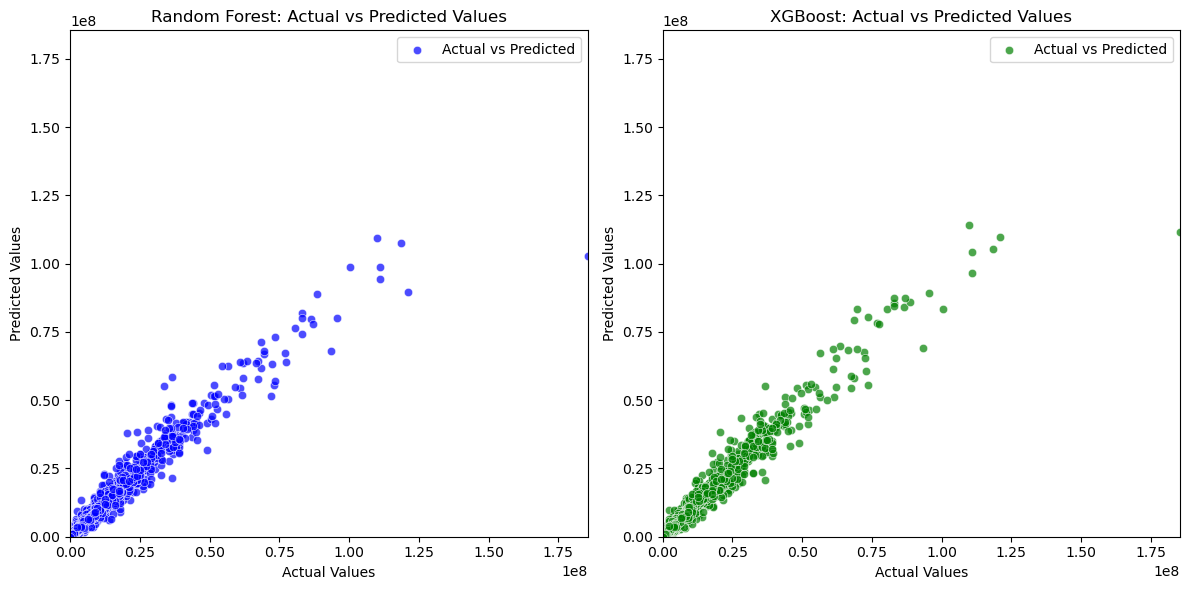

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

y_pred_rf = rf.predict(X_test)
# Plot für den RF
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7, color='blue', label='Actual vs Predicted')
plt.title("Random Forest: Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

# Setzen der selben Limiten zur Übersicht
rf_max_limit = max(y_test.max(), y_pred_rf.max())
plt.xlim(0, rf_max_limit)
plt.ylim(0, rf_max_limit)

# RMSE für RF
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE for Random Forest:", rmse_rf)

# Plot für XGB
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_test_xgb, alpha=0.7, color='green', label='Actual vs Predicted')
plt.title("XGBoost: Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()

# Setzen der selben Limiten zur besseren Übersicht
xgb_max_limit = max(y_test.max(), y_pred_test_xgb.max())
plt.xlim(0, xgb_max_limit)
plt.ylim(0, xgb_max_limit)

#RMSE für für XGB
rmse_xgb = mean_squared_error(y_test, y_pred_test_xgb, squared=False)
print("RMSE for XGBoost:", rmse_xgb)

plt.tight_layout()
plt.show()
# Quelle: ChatGPT; Prompt: Create two plots that are both next to each other so that i can easily compare them, for my model xgboost and my model with random forests

# Interpretation und Modell Auswahl:
>Wie wir hier im Plot erkennen können haben wir eine ungefähre Diagonale mit eingen  Ausreissern. XGB ist eine ein wenig dünnere "Linie", die konzentrierter ist, auch der RMSE ist etwas kleiner, weshalb ich mich schlussendlich für dieses Modell entschieden habe.
>Deshalb werde ich nun noch die finale Analyse mit dem zweiten comp_data-Set dürchführen.


# XGBoost auf comp_data:

In [147]:
#Anwenden des XGBModells auf den competition Daten:
X_comp_data = comp_data[['ID', 'potential', 'age', 'league_level', 'skill_moves', 'international_reputation',
                         'pace', 'shooting', 'passing', 'dribbling', 'defending', 'club_contract_valid_until',
                         'height_cm', 'year']]

# Prediction
y_pred_comp_data = best_xgb_model.predict(X_comp_data)

# Hinzufügen der predictedvalues zum comp_data-Frame
comp_data['comp_predictions'] = y_pred_comp_data
comp_data.head()
#Quelle: ChatGPT; Prompt: best_xgb_model code + how can i use this model on a different df names comp_data

,ID,potential,age,league_level,skill_moves,international_reputation,pace,shooting,passing,dribbling,defending,club_contract_valid_until,height_cm,year,comp_predictions
0,14644,69,22,1.0,2,1,59.0,61.0,47.0,56.0,24.0,2024.0,195,2022,1611845.625
1,8357,73,22,2.0,3,1,82.0,64.0,60.0,68.0,31.0,2024.0,178,2022,3171950.250
2,8245,72,23,1.0,3,1,81.0,47.0,60.0,61.0,61.0,2025.0,180,2022,2365071.000
3,5290,75,22,2.0,1,1,71.8,47.0,60.2,66.2,65.2,2024.0,186,2022,2255634.500
4,5169,76,23,2.0,2,1,64.0,31.0,54.0,61.0,71.0,2026.0,186,2022,2272298.500


In [133]:
#Erstellen eines CSV-Files mit den KaggleDaten
model_name = "ATestSubmissionKagle5.csv"

In [134]:
def save_submission_for_kaggle(model_name, y_pred_comp_data, comp_data):
  import pandas as pd
  submission_data = pd.DataFrame({"ID": comp_data["ID"], "Actual": y_pred_comp_data})
  submission_data.to_csv(model_name, index=False)


In [135]:
save_submission_for_kaggle(model_name, y_pred_comp_data, comp_data)